# @robotodio - tweet extractor

---

## Libraries

In [1]:
# Python libraries
# ------------------------------------------------------------------------------
# Reading files with different formats
import json

# Data wrangling
import re
import pandas as pd
import numpy as np

# Data Visualitation
import seaborn as sns
import matplotlib.pyplot as plt

# Twitter API
import tweepy

# NLP
from textblob import TextBlob
from googletrans import Translator

# Hate speech detection
from detoxify import Detoxify

## 1. Download data from twitter

The tweepy API class provides access to the entire Twitter RESTful API methods. Each method can accept various parameters and return responses to the different requests.

### 1.1. API set up

In order for you to get the Twitter feed working you need four keys: 

- Consumer Key
- Consumer Secret
- Access Token
- Access Token Secret

If you have a developer Twitter account you can generate your own tokens and log in with them. In case you don't have a developer account, please contact me and I will provide mine.

In [2]:
# API Twitter credentials
# ------------------------------------------------------------------------------
# Open .json file containing credentials/tokens as a dictionary
with open("../twitter_api_keys.json") as file:
    api_credentials = json.load(file)
    
# Assign each value of the dictionary to a new variable
consumer_key = api_credentials['consumer_key']
consumer_secret = api_credentials['consumer_secret']
access_token = api_credentials['access_token']
access_token_secret = api_credentials['access_token_secret']

In [3]:
# API set up
# ------------------------------------------------------------------------------
# Create a handler instance with key and secret consumer, and pass the tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
    
# Construct the API instance
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Check credentials
if(api.verify_credentials):
    print('-'*30)
    print("Logged In Successfully.")
    print('-'*30)
else:
    print("Error -- Could not log in with your credentials.")

------------------------------
Logged In Successfully.
------------------------------


### 1.2. Extract tweets and associated metadata

Once the `tweepy.API` class has been instantiated we can call its methods to scrap desired information in Twitter.

Pagination is used a lot in Twitter API development. Iterating through timelines, user lists, direct messages, etc. In order to perform pagination, we must supply a page/cursor parameter with each of our requests. The problem here is this requires a lot of boiler plate code just to manage the pagination loop. To help make pagination easier and require less code, Tweepy has the Cursor object.

In first place, we are going to define a function that returns an iterator of tweets. We will call this fuction each time we want to download tweets from an user account.

In [12]:
# Tweets list iterator
# ------------------------------------------------------------------------------
def tweets_iterator(target, n_items):
    '''
    Returns an iterator of tweets.

        Parameters:
            target (str): The user name of the Twitter account.
            n_items (int): Number of tweets downloaded.

        Returns:
            tweets (ItemIterator): an iterator of tweets.
    '''
    # Instantiate the iterator
    tweets = tweepy.Cursor(
        api.user_timeline,
        screen_name=target,
        include_rts=False,
        exclude_replies=False,
        tweet_mode='extended').items(n_items)
    
    # Returns iterator
    return tweets

In the next cell we are going to download $n$ tweets from a Twitter account, and examinate the content of the first tweet with all the metadata associated.

In [13]:
# Introduce the target Twitter account and number of items to download
target = 'DFD_74'
n_items = 500

# Tweets list (iterator)
tweets = tweets_iterator(target, n_items=1)

# Print the first tweet with .json format
print(json.dumps(next(tweets)._json, indent=4))

{
    "created_at": "Sat Mar 06 11:49:35 +0000 2021",
    "id": 1368166868587077641,
    "id_str": "1368166868587077641",
    "full_text": "@Denna12_0 Exacto. Cuando pasen unos d\u00edas y suban los casos en Madrid dir\u00e1n, \u00bfveis como el 8M no es culpable? \nTrileros de medio pelo",
    "truncated": false,
    "display_text_range": [
        11,
        133
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [
            {
                "screen_name": "Denna12_0",
                "name": "Mrs Guerrera ^..^\ud83c\udf80\u2694\ufe0f\ud83d\udc99\ud83c\uddea\ud83c\uddf8",
                "id": 947146374499446785,
                "id_str": "947146374499446785",
                "indices": [
                    0,
                    10
                ]
            }
        ],
        "urls": []
    },
    "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>",
    "in_reply_to_status_id": 1

As we can see in the previous output cell, each tweet contains a lot of metadata. All this information comes in .json format, and we can access to it with Tweepy methods, or with dictionary methods.

In the next cell we are going to extract some metadata from each tweet, and export to a Pandas DataFrame format.

In [14]:
# Tweet extractor
# ------------------------------------------------------------------------------
# Tweets list (iterator)
tweets = tweets_iterator(target, n_items)

# Read through the iterator, and export the info to a Pandas DataFrame
all_columns = [np.array([
    tweet.full_text,
    tweet.user.screen_name,
    tweet.id,
    tweet.user.followers_count,
    tweet.source,
    tweet.created_at,
    tweet.lang,
    len(tweet.full_text),
    tweet.favorite_count,
    tweet.retweet_count,
    re.findall(r"#(\w+)", tweet.full_text)
]) for tweet in tweets]

# Export the list of tweets to a dataframe
df = pd.DataFrame(
    data=all_columns,
    columns=['tweet', 'account', 'id', 'followers', 'source', 'date', 'language',
             'length', 'likes', 'RTs', 'hashtags'])

df.head()

<ipython-input-14-6436858e4064>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_columns = [np.array([


,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags
0,@Denna12_0 Exacto. Cuando pasen unos días y su...,DFD_74,1368166868587077641,5786,Twitter for Android,2021-03-06 11:49:35,es,133,1,1,[]
1,Pensad porque solo han anulado el 8M en Madrid...,DFD_74,1368166285599772681,5786,Twitter for Android,2021-03-06 11:47:16,es,72,5,1,[]
2,El día de la mujer trabajadora se ha convertid...,DFD_74,1368165789707218950,5786,Twitter for Android,2021-03-06 11:45:18,es,130,4,3,[]
3,@AnitaBotwin @eledhmel Mira que eres analfabet...,DFD_74,1368162969616584705,5786,Twitter for Android,2021-03-06 11:34:05,es,53,1,0,[]
4,UGTT\n\nUNIÓN de \nGILIPOLLAS \nTONTOS y \nTRI...,DFD_74,1367955417071038475,5786,Twitter for Android,2021-03-05 21:49:21,es,62,15,8,[]


In addition, we are going to create another dataframe with the main data of the target account:

In [15]:
# Account data extractor
# ------------------------------------------------------------------------------
# Tweets list (iterator)
tweets = tweets_iterator(target, n_items=1)

# Read through the iterator, and export the info to a Pandas DataFrame
data_account = [np.array([
    tweet.user.screen_name,
    tweet.user.name,
    tweet.user.description,
    tweet.user.created_at,
    tweet.user.friends_count,
    tweet.user.followers_count,
    tweet.user.statuses_count
]) for tweet in tweets]

# Export the list of features to a dataframe
df_account = pd.DataFrame(
    data=data_account,
    columns=['account', 'account_name', 'bio_description', 'creation_date', 'friends',
             'followers', 'tweets']
)

df_account = pd.melt(df_account)
df_account

,variable,value
0,account,DFD_74
1,account_name,Español74 (david) 🇪🇸
2,bio_description,"Padre orgulloso, marido enamorado, currante, e..."
3,creation_date,2017-09-15 09:52:18
4,friends,588
5,followers,5786
6,tweets,61365


### 1.3. Clean and translation

Once we have a dataset with all the tweets of an user, we need to prepare and clean them to serve as input to the model. For each tweet we are going to eliminate special string characters, and we will translate them into English in case they are not.

The traduction is needed for two mains reasons:

- Make a more robust and extensible app
- Detoxify model provides more information when the input is in english language

**Cleaning:**

In [16]:
# Data cleaning
# ------------------------------------------------------------------------------
# Characters to remove
spec_chars = ['\n', '\t', '\r']

# Replace defined characters with a whitespace
for char in spec_chars:
    df['tweet'] = df['tweet'].str.strip().replace(char, ' ')

Because we replaced the special characters with a whitespace, we might end up with double whitespaces in some values. Let’s remove them by splitting each tweet using whitespaces and re-joining the words again using join.

In [17]:
# Split and re-join each tweet
df['tweet'] = df['tweet'].str.split().str.join(" ")

In [18]:
df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags
0,@Denna12_0 Exacto. Cuando pasen unos días y su...,DFD_74,1368166868587077641,5786,Twitter for Android,2021-03-06 11:49:35,es,133,1,1,[]
1,Pensad porque solo han anulado el 8M en Madrid...,DFD_74,1368166285599772681,5786,Twitter for Android,2021-03-06 11:47:16,es,72,5,1,[]
2,El día de la mujer trabajadora se ha convertid...,DFD_74,1368165789707218950,5786,Twitter for Android,2021-03-06 11:45:18,es,130,4,3,[]
3,@AnitaBotwin @eledhmel Mira que eres analfabet...,DFD_74,1368162969616584705,5786,Twitter for Android,2021-03-06 11:34:05,es,53,1,0,[]
4,UGTT UNIÓN de GILIPOLLAS TONTOS y TRILEROS @UG...,DFD_74,1367955417071038475,5786,Twitter for Android,2021-03-05 21:49:21,es,62,15,8,[]


## 2. Hate speech level prediction

`Detoxify` library has three pre-trained models:

- original: toxic, severe_toxic, obscene, threat, insult, identity_hate.
- unbiased: toxicity, severe_toxicity, obscene, threat, insult, identity_attack, sexual_explicit.
- multilingual: toxicity

While *original* and *unbiased* models generate different scorings like: toxicity, obscene, threat, insult...etc, *multilingual* model only produces a toxicity scoring. On the other hand, *multilingual* model is the only one that can bring a toxicity score in a language different from english.

Thanks to translation, we can use *original* or *unbiased* model independently from the tweets origin language.

In [19]:
# Hate speech level prediction
# ------------------------------------------------------------------------------
# Returns a dictionary with toxicity values of each tweet. The keys of the
# dictionary are called 'toxicity', 'obscene'...etc
results = Detoxify('multilingual').predict(list(df['tweet']))
results

{'toxicity': [0.007524342741817236,
  0.001926364260725677,
  0.03101147525012493,
  0.5895219445228577,
  0.40199902653694153,
  0.030037449672818184,
  0.09294970333576202,
  0.006322591565549374,
  0.0005494042998179793,
  0.2844538688659668,
  0.8887885212898254,
  0.0012488270876929164,
  0.6757118701934814,
  0.0005103926523588598,
  0.0018549460219219327,
  0.04102478548884392,
  0.7529625296592712,
  0.9579599499702454,
  0.13285616040229797,
  0.7976221442222595,
  0.006738417781889439,
  0.8230490684509277,
  0.938224196434021,
  0.0005716452724300325,
  0.03382601588964462,
  0.003669122466817498,
  0.005984276998788118,
  0.5902559757232666,
  0.4427201449871063,
  0.3211522400379181,
  0.0037173847667872906,
  0.7726693153381348,
  0.02370140701532364,
  0.000708797771949321,
  0.5243580937385559,
  0.08527737855911255,
  0.007345861289650202,
  0.853099524974823,
  0.2110380232334137,
  0.005615968722850084,
  0.009140395559370518,
  0.029865920543670654,
  0.001529664034

In [20]:
# Add the new info to the previous DataFrame
df['toxicity'] = results['toxicity']

df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity
0,@Denna12_0 Exacto. Cuando pasen unos días y su...,DFD_74,1368166868587077641,5786,Twitter for Android,2021-03-06 11:49:35,es,133,1,1,[],0.007524
1,Pensad porque solo han anulado el 8M en Madrid...,DFD_74,1368166285599772681,5786,Twitter for Android,2021-03-06 11:47:16,es,72,5,1,[],0.001926
2,El día de la mujer trabajadora se ha convertid...,DFD_74,1368165789707218950,5786,Twitter for Android,2021-03-06 11:45:18,es,130,4,3,[],0.031011
3,@AnitaBotwin @eledhmel Mira que eres analfabet...,DFD_74,1368162969616584705,5786,Twitter for Android,2021-03-06 11:34:05,es,53,1,0,[],0.589522
4,UGTT UNIÓN de GILIPOLLAS TONTOS y TRILEROS @UG...,DFD_74,1367955417071038475,5786,Twitter for Android,2021-03-05 21:49:21,es,62,15,8,[],0.401999


Once we have a score for each tweet, we can define a toxicity threshold and aggregate these puntuactions by calculating the average. According to Detoxify documentation, a tweet can be toxic when the score is around 0.5.

> *Each comment in Train has a toxicity label (target), and models should predict the target toxicity for the Test data. This attribute (and all others) are fractional values which represent the fraction of human raters who believed the attribute applied to the given comment. For evaluation, test set examples with target >= 0.5 will be considered to be in the positive class (toxic).
URL: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data*

In [21]:
# Define a class for each tweet
df['class'] = df['toxicity'].apply(lambda toxicity: 'toxic' if toxicity >= 0.5 else 'non-toxic')
df.head()

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity,class
0,@Denna12_0 Exacto. Cuando pasen unos días y su...,DFD_74,1368166868587077641,5786,Twitter for Android,2021-03-06 11:49:35,es,133,1,1,[],0.007524,non-toxic
1,Pensad porque solo han anulado el 8M en Madrid...,DFD_74,1368166285599772681,5786,Twitter for Android,2021-03-06 11:47:16,es,72,5,1,[],0.001926,non-toxic
2,El día de la mujer trabajadora se ha convertid...,DFD_74,1368165789707218950,5786,Twitter for Android,2021-03-06 11:45:18,es,130,4,3,[],0.031011,non-toxic
3,@AnitaBotwin @eledhmel Mira que eres analfabet...,DFD_74,1368162969616584705,5786,Twitter for Android,2021-03-06 11:34:05,es,53,1,0,[],0.589522,toxic
4,UGTT UNIÓN de GILIPOLLAS TONTOS y TRILEROS @UG...,DFD_74,1367955417071038475,5786,Twitter for Android,2021-03-05 21:49:21,es,62,15,8,[],0.401999,non-toxic


In [22]:
scoring_average = {'variable': ['avg_toxicity'],
                   'value': [df['toxicity'].mean()]}

df_average = pd.DataFrame(scoring_average)
df_average

,variable,value
0,avg_toxicity,0.301907


In [23]:
df_account = pd.concat([df_account, df_average])
df_account

,variable,value
0,account,DFD_74
1,account_name,Español74 (david) 🇪🇸
2,bio_description,"Padre orgulloso, marido enamorado, currante, e..."
3,creation_date,2017-09-15 09:52:18
4,friends,588
5,followers,5786
6,tweets,61365
0,avg_toxicity,0.301907


## 3. Data explotation

In [35]:
# Top 5 toxic tweets
top_5 = df.sort_values('toxicity', ascending=False).head()
top_5

,tweet,account,id,followers,source,date,language,length,likes,RTs,hashtags,toxicity,class
328,"Esa gente gilipollas, que son pro aborto y pro...",DFD_74,1363485288237043718,5786,Twitter for Android,2021-02-21 13:46:39,es,122,20,10,[],0.996098,toxic
93,@okdiario @MagdaDG1 Traduzco. Te va a patear e...,DFD_74,1366346111686967298,5786,Twitter for Android,2021-03-01 11:14:33,es,61,11,1,[],0.994586,toxic
306,De han quedado cortos. Eres escoria. Y no te q...,DFD_74,1363596975145426946,5786,Twitter for Android,2021-02-21 21:10:27,es,109,10,2,[],0.994112,toxic
324,"Hay idiotas, hay imbéciles, hay subnormales, l...",DFD_74,1363492855491284992,5786,Twitter for Android,2021-02-21 14:16:43,es,98,188,56,[],0.992879,toxic
170,A ver si os vais enterando idiotas: Nos import...,DFD_74,1365041016236093441,5786,Twitter for Android,2021-02-25 20:48:34,es,137,25,10,[],0.991109,toxic


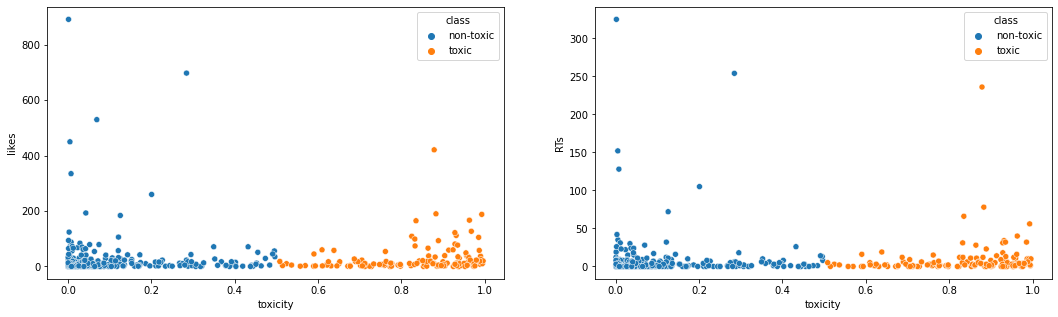

In [24]:
# Toxicity vs. Likes & RTs
fig, ax = plt.subplots(1, 2, figsize=(18,5))

sns.scatterplot(ax=ax[0], data=df, x='toxicity', y='likes', hue='class')
sns.scatterplot(ax=ax[1], data=df, x='toxicity', y='RTs', hue='class');

In [27]:
max(df['followers'])


5786

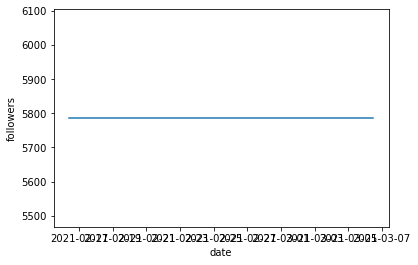

In [25]:
# Followers growth
fig, ax = plt.subplots()
sns.lineplot(data=df, x='date', y='followers', ax=ax)
ax.set_xlim(,31);

In [ ]:
# Ver para 
sns.catplot(data=penguins, x='bill_length_mm', y='species', hue='sex', kind='strip');

## X. Bibliografía

- http://docs.tweepy.org/en/latest/
- https://github.com/unitaryai/detoxify

## X. Info a revisar

- Limpieza de datos con regex: http://rios.tecnm.mx/cdistribuido/recursos/MinDatScr/MineriaScribble.html
- Web objetivo: https://www.ninjalitics.com/


- Traduction --> TextBlob
- Sentiment Analysis --> TextBlob
- Universal Dependencies --> GSD

Preparar un traductor con TextBlob:

TextBlob también tiene análisis de opinión:

In [ ]:
https://blog.usejournal.com/why-and-how-to-make-a-requirements-txt-f329c685181e